# Residual networks with PyTorch

In this example, we'll implement the various types of residual blocks using PyTorch. We'll train the network on the CIFAR-10 dataset.

Let's start with the imports:

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

We'll continue by implementing the pre-activation non-bottleneck residual block, which is a subclass of `torch.nn.Module`:

In [2]:
class PreActivationBlock(nn.Module):
    """Pre-activation residual block."""

    expansion = 1

    def __init__(self, in_slices, slices, stride=1):
        super(PreActivationBlock, self).__init__()

        self.bn_1 = nn.BatchNorm2d(in_slices)
        self.conv_1 = nn.Conv2d(in_channels=in_slices, out_channels=slices,
                                kernel_size=3, stride=stride, padding=1,
                                bias=False)

        self.bn_2 = nn.BatchNorm2d(slices)
        self.conv_2 = nn.Conv2d(in_channels=slices, out_channels=slices,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)

        # if the input/output dimensions differ use convolution for the shortcut
        if stride != 1 or in_slices != self.expansion * slices:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_slices,
                          out_channels=self.expansion * slices,
                          kernel_size=1,
                          stride=stride,
                          bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn_1(x))

        #  reuse bn+relu in down-sampling layers
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x

        out = self.conv_1(out)

        out = F.relu(self.bn_2(out))
        out = self.conv_2(out)

        out += shortcut

        return out

We'll continue with the implementation of the pre-activation bottleneck residual block:

In [3]:
class PreActivationBottleneckBlock(nn.Module):
    """Pre-activation bottleneck residual block."""

    expansion = 4

    def __init__(self, in_slices, slices, stride=1):
        super(PreActivationBottleneckBlock, self).__init__()

        self.bn_1 = nn.BatchNorm2d(in_slices)
        self.conv_1 = nn.Conv2d(in_channels=in_slices, out_channels=slices,
                                kernel_size=1,
                                bias=False)

        self.bn_2 = nn.BatchNorm2d(slices)
        self.conv_2 = nn.Conv2d(in_channels=slices, out_channels=slices,
                                kernel_size=3, stride=stride, padding=1,
                                bias=False)

        self.bn_3 = nn.BatchNorm2d(slices)
        self.conv_3 = nn.Conv2d(in_channels=slices,
                                out_channels=self.expansion * slices,
                                kernel_size=1,
                                bias=False)

        # if the input/output dimensions differ use convolution for the shortcut
        if stride != 1 or in_slices != self.expansion * slices:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_slices,
                          out_channels=self.expansion * slices,
                          kernel_size=1, stride=stride,
                          bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn_1(x))

        #  reuse bn+relu in down-sampling layers
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x

        out = self.conv_1(out)

        out = F.relu(self.bn_2(out))
        out = self.conv_2(out)

        out = F.relu(self.bn_3(out))
        out = self.conv_3(out)

        out += shortcut

        return out

Next, we'll implement a configurable ResNet class, which works with both types of pre-activation blocks. The network takes as input the type of pre-activation block, the number of residual groups, the number of residual blocks in each group, and the number of output classes (10 in the case of CIFAR-10). The class builds the network according to these parameters:

In [4]:
class PreActivationResNet(nn.Module):
    """Pre-activation residual network"""

    def __init__(self, block, num_blocks, num_classes=10):
        """
        :param block: type of residual block (regular or bottleneck)
        :param num_blocks: a list with 4 integer values.
            Each value reflects the number of residual blocks in the group
        :param num_classes: number of output classes
        """

        super(PreActivationResNet, self).__init__()

        self.in_slices = 64

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)

        self.layer_1 = self._make_group(block, 64, num_blocks[0], stride=1)
        self.layer_2 = self._make_group(block, 128, num_blocks[1], stride=2)
        self.layer_3 = self._make_group(block, 256, num_blocks[2], stride=2)
        self.layer_4 = self._make_group(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_group(self, block, slices, num_blocks, stride):
        """Create one residual group"""

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_slices, slices, stride))
            self.in_slices = slices * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

Next, we'll define several `PreActivationResNet` configurations, which match the configuration of the original ResNet papers:

In [5]:
def PreActivationResNet18():
    return PreActivationResNet(block=PreActivationBlock,
                               num_blocks=[2, 2, 2, 2])


def PreActivationResNet34():
    return PreActivationResNet(block=PreActivationBlock,
                               num_blocks=[3, 4, 6, 3])


def PreActivationResNet50():
    return PreActivationResNet(block=PreActivationBottleneckBlock,
                               num_blocks=[3, 4, 6, 3])


def PreActivationResNet101():
    return PreActivationResNet(block=PreActivationBottleneckBlock,
                               num_blocks=[3, 4, 23, 3])


def PreActivationResNet152():
    return PreActivationResNet(block=PreActivationBottleneckBlock,
                               num_blocks=[3, 8, 36, 3])


We'll continue with the implementation of the model training routine, which is generic and is not specifically related to the `PreActivationResNet`:

In [8]:
def train_model(model, loss_function, optimizer, data_loader):
    """Train one epoch"""

    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

Then, we'll implement the validation routine:

In [9]:
def test_model(model, loss_function, data_loader):
    """Test for a single epoch"""

    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

    return total_loss, total_acc

We'll continue with the `plot_accuracy` function (the name speaks for itself):

In [10]:
def plot_accuracy(accuracy: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

We now have all the ingredients to build, train, and validate the model. Let's start by instantiating the training dataset transformations (`transform_train`) and `train_loader`:

In [11]:
# training data transformation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])

# training data loader
train_set = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform_train)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=2)

Files already downloaded and verified


Let's do the same for the validation dataset:

In [12]:
# test data transformation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])

# test data loader
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=2)

Files already downloaded and verified


We'll continue by instantiating the `device`, `model`, `loss_function`, and the `optimizer`:

In [13]:
# load the model
model = PreActivationResNet34()

# select gpu 0, if available
# otherwise fallback to cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# transfer the model to the GPU
model = model.to(device)

# loss function
loss_function = nn.CrossEntropyLoss()

# We'll optimize all parameters
optimizer = optim.Adam(model.parameters())

Finally, we'll run the training for 15 epochs and we'll plot the accuracy at the end:

Epoch 1/15
Train Loss: 1.5397; Accuracy: 0.4284
Test Loss: 1.3968; Accuracy: 0.4944
Epoch 2/15
Train Loss: 1.2436; Accuracy: 0.5450
Test Loss: 1.1301; Accuracy: 0.6010
Epoch 3/15
Train Loss: 1.0482; Accuracy: 0.6239
Test Loss: 0.9587; Accuracy: 0.6745
Epoch 4/15
Train Loss: 0.8672; Accuracy: 0.6948
Test Loss: 0.8985; Accuracy: 0.6996
Epoch 5/15
Train Loss: 0.7243; Accuracy: 0.7480
Test Loss: 0.6420; Accuracy: 0.7819
Epoch 6/15
Train Loss: 0.6335; Accuracy: 0.7836
Test Loss: 0.6720; Accuracy: 0.7736
Epoch 7/15
Train Loss: 0.5695; Accuracy: 0.8058
Test Loss: 0.5958; Accuracy: 0.8042
Epoch 8/15
Train Loss: 0.5033; Accuracy: 0.8262
Test Loss: 0.5246; Accuracy: 0.8223
Epoch 9/15
Train Loss: 0.4667; Accuracy: 0.8429
Test Loss: 0.5277; Accuracy: 0.8344
Epoch 10/15
Train Loss: 0.4256; Accuracy: 0.8554
Test Loss: 0.4896; Accuracy: 0.8371
Epoch 11/15
Train Loss: 0.3892; Accuracy: 0.8671
Test Loss: 0.4600; Accuracy: 0.8609
Epoch 12/15
Train Loss: 0.3638; Accuracy: 0.8741
Test Loss: 0.4029; Accura

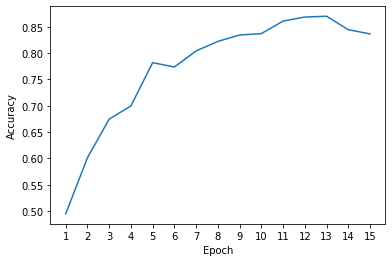

In [15]:
EPOCHS = 15

test_acc = list()  # collect accuracy for plotting
for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch + 1, EPOCHS))

    train_model(model, loss_function, optimizer, train_loader)
    _, acc = test_model(model, loss_function, test_loader)
    test_acc.append(acc)

plot_accuracy(test_acc)